In [1]:
from io import open
import random
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import wandb
import pandas as pd
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
import numpy as np

In [2]:
noDict = True
Testing = False
attentionRecord = []
bestConfig = True
loaded = False

In [3]:
class PrepText():
    def __init__ (self, maxSize):
        self.textToNumX = {}
        self.numToTextX = {}
        self.textToNumY = {}
        self.numToTextY = {}
        self.encodingLength = maxSize
        self.noDict = True


    def makeDict(self, wordsX, wordsY):
        #print ("creating the dictionary.")


        self.textToNumX["PAD"] = 0
        self.textToNumX["SOS"] = 1
        self.textToNumX["EOS"] = 2
        self.count = 3
        for word in wordsX:
            for letter in word:
                if letter not in self.textToNumX:
                    self.textToNumX[letter] = self.count
                    self.count+=1

        
        for letter, number in self.textToNumX.items():
            self.numToTextX[number] = letter

        self.textToNumY["PAD"] = 0
        self.textToNumY["SOS"] = 1
        self.textToNumY["EOS"] = 2
        self.count = 3
        for word in wordsY:
            for letter in word:
                if letter not in self.textToNumY:
                    self.textToNumY[letter] = self.count
                    self.count+=1

        
        for letter, number in self.textToNumY.items():
            self.numToTextY[number] = letter
        print (self.textToNumY)
        print (self.textToNumX)
        print ("=============")
        
        print (self.numToTextX)
        print (self.numToTextY)
        
        self.noDict = False
    
    def lenOutput(self):
        return len(self.numToTextY);


    def lenInput(self):
        return len(self.numToTextX);
    
    def getHinDict (self):
        
        return self.textToNumY

        
    def vectorizeOneWord(self, wordX, wordY):
        self.vectorX = torch.zeros(self.encodingLength, dtype = torch.int)
        self.vectorY = torch.zeros(self.encodingLength, dtype = torch.int)


        #print("encoding english word: " + wordX + " encoding hindi word: " + wordY)

        self.count = 1
        self.vectorX[0] = self.textToNumX['SOS']
        for letter in wordX:
            if letter not in self.textToNumX:
                self.vectorX[self.count] = -1
                continue
            self.vectorX[self.count] = self.textToNumX[letter]
            self.count += 1
        self.vectorX[self.count] = self.textToNumX['EOS']



        self.count = 1
        self.vectorY[0] = self.textToNumY['SOS']
        for letter in wordY:
            if letter not in self.textToNumY:
                self.vectorY[self.count] = -1
                continue
            self.vectorY[self.count] = self.textToNumY[letter]
            self.count += 1
        self.vectorY[self.count] = self.textToNumY['EOS']
        
        self.count = 1

        return self.vectorX, self.vectorY

    def vectorToWord (self, x):
        wordA = ""

        for element in x:
            if element.item() == -1:
                wordA += "</unk>"
                continue
            if element.item () == 0 or element.item() == 1 or element.item() == 2:
                continue
            wordA += self.numToTextY[element.item()]


        return wordA


In [4]:
class AksharantarData(Dataset):

    def __init__(self, rootPath, max_size, prepTextObj):

        self.root  = rootPath
        self.df = pd.read_csv(self.root, names = ["english", "hindi"])


        self.english = self.df["english"]
        self.hindi = self.df["hindi"]


        self.vocab = prepTextObj
        
        if self.vocab.noDict == True:
            self.vocab.makeDict(self.english, self.hindi)

    
    def convertBack(self, inputX, inputY):
        return self.vocab.vectorToWord(inputX, inputY)


    def lenOutput(self):
        return self.vocab.lenOutput()


    def lenInput(self):
        return self.vocab.lenInput()

    def getDictEng (self):
        return self.vocab.textToNumX;

    def getDictHin (self):
        return self.vocab.textToNumY;

    
    def __len__(self):

        return len(self.df)


    def __getitem__ (self, idx):

        #print(idx)

        self.englishWord = self.english[idx]
        #print(self.englishWord)
        self.hindiWord = self.hindi[idx]
        #print(self.hindiWord)
        self.vecEncodedX, self.vecEncodedY = self.vocab.vectorizeOneWord(self.englishWord, self.hindiWord)
        return (self.vecEncodedX, self.vecEncodedY)

In [5]:
def createData(encodingLength, batchSize):  
    

    dataPrepper = PrepText (encodingLength)
    
    
    # training data.
    trainData = AksharantarData("/kaggle/input/aksharantar1/aksharantar_sampled/hin/hin_train.csv", encodingLength, dataPrepper)

    # validation data.
    valData = AksharantarData("/kaggle/input/aksharantar1/aksharantar_sampled/hin/hin_valid.csv", encodingLength, dataPrepper) 

    # testing data.
    testData = AksharantarData("/kaggle/input/aksharantar1/aksharantar_sampled/hin/hin_test.csv", encodingLength, dataPrepper)


    # determine the lengths of the different datasets.
    lenIn = trainData.lenInput()
    lenOut = trainData.lenOutput()


    # train data loader.
    trainLoader = DataLoader(trainData, shuffle = False, batch_size = batchSize)

    # validation data loader.
    valLoader = DataLoader(valData, shuffle = False, batch_size = batchSize)

    # test data loader.
    testLoader = DataLoader(testData, shuffle = False, batch_size = batchSize)

    # currently set it to false for debugging purposes.
    input_size = lenIn+1
    output_size = lenOut+1
    
    
    return lenIn, lenOut, dataPrepper, trainLoader,valLoader, testLoader

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p, biDirection, RNN):
        super(EncoderRNN, self).__init__()
        self.dropout = nn.Dropout(p)
        self.RNN = RNN

        self.embedding = nn.Embedding(input_size, embedding_size)
        
        if (RNN == "LSTM"):
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p, batch_first=True, bidirectional = biDirection )
        if (RNN == "GRU"):
            self.rnn = nn.GRU (embedding_size, hidden_size, num_layers, dropout=p, batch_first=True, bidirectional = biDirection )
        if (RNN == "RNN"):
            self.rnn = nn.RNN (embedding_size, hidden_size, num_layers, dropout=p, batch_first=True, bidirectional = biDirection )
        
    def forward(self, x):

        embedding = self.dropout(self.embedding(x))
        
        if self.RNN == "LSTM":
            outputs, (hidden, cell) = self.rnn(embedding)
            
        if self.RNN == "GRU":
            outputs, hidden = self.rnn (embedding)
            
        if self.RNN == "RNN":
            outputs, hidden = self.rnn (embedding)
        
        del (embedding)
        torch.cuda.empty_cache()
        
        
        if self.RNN == "LSTM":
            return outputs, hidden, cell
        else:
            return outputs, hidden

In [7]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p, biDirection, RNN):
        
        
        super(DecoderRNN, self).__init__()
        self.dropout = nn.Dropout(p)
        self.RNN = RNN
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        
        self.Wattn = nn.Linear (hidden_size, hidden_size, bias = False)
        
        self.Uattn = nn.Linear (hidden_size, hidden_size, bias = False)
        
        self.Vattn = nn.Linear (hidden_size, 1, bias = False)
        
        if RNN == "LSTM":
            self.rnn = nn.LSTM(embedding_size + hidden_size, hidden_size, num_layers, dropout=p, bidirectional = biDirection, batch_first = True)
            
        if RNN == "RNN":
            self.rnn = nn.RNN (embedding_size + hidden_size, hidden_size, num_layers, dropout=p, bidirectional = biDirection, batch_first = True)
            
        if RNN == "GRU":
            self.rnn = nn.GRU (embedding_size + hidden_size, hidden_size, num_layers, dropout=p, bidirectional = biDirection, batch_first = True)

        self.fc = nn.Linear(hidden_size*(int(biDirection)+1), output_size)

    def forward(self, x, encoder_output, hidden, cell, batch_size):

        x = x.unsqueeze(0)

        embedding = self.dropout(self.embedding(x))
        
        embedding = embedding.permute (1,0,2)

        Uattn = self.Uattn (encoder_output)
        Wattn = self.Wattn (hidden[-1])
        
        temp = Uattn + Wattn.resize (batch_size, 1, self.hidden_size)
        
        temp1 = torch.nn.functional.tanh (temp)
        
        
        ejt = self.Vattn (temp1)
        
        ajt = torch.nn.Softmax (dim = 1)(ejt)
        
        
        ct = torch.bmm (ajt.transpose(1,2), encoder_output)
        
        
        hello = torch.cat((embedding, ct), dim = 2)
        
        if Testing == True:
            #print ("appending to attentionRecord")
            attentionRecord.append (ajt)
            #print (ajt)
        #print ("here in decoder RNN")
        
        
        if (self.RNN == "LSTM"):
            outputs, (hidden, cell) = self.rnn(hello)
        else :
            outputs, hidden = self.rnn (hello)

        predictions = self.fc(outputs)

        predictions = predictions.squeeze(0)
        
        
        del (outputs)
        del (hello)
        del (ct)
        del (ajt)
        del (ejt)
        del (temp1)
        del (temp)
        del (Uattn)
        del (Wattn)
        del (embedding)
        
        torch.cuda.empty_cache()
        if self.RNN == "LSTM":
            return predictions, hidden, cell
        else:
            return predictions, hidden

In [8]:
import gc
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, outputSize, RNN):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.outputSize = outputSize
        self.RNN = RNN


    def forward(self, source, target, teacherForce = 0):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.outputSize


        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        
        
        if self.RNN == "LSTM":
            encoder_output, hidden, cell = self.encoder(source)
        
        else :
            encoder_output, hidden = self.encoder(source)
            
        
        x = target[:,0]
        outputs[0] = torch.ones(outputs[0].shape)

        for t in range(1, target_len):
            
            if self.RNN == "LSTM":
                output, hidden, cell = self.decoder(x, encoder_output, hidden, cell, batch_size)
                
            else :
                output, hidden = self.decoder (x, encoder_output, hidden, None, batch_size)
            
              
            output = output.resize (batch_size,67)    
            
            outputs[t] = output

            best_guess = output.argmax(dim =1)
    

            x = target[:,t] if random.random() < teacherForce  else best_guess
        
        
        del (hidden)
        if self.RNN == "LSTM":
            del (cell)
        del (best_guess)
        del (target)
        del (x)
        torch.cuda.empty_cache()


        return outputs

            

In [31]:
def accuracy(model,dataLoader,batch_size):
    
    
    correct=0
    
    
    for x,y in dataLoader:
        
        
        
        x ,y = x.to(device), y.to (device)
        output=model(x,y,0)
        output = nn.Softmax (dim=2) (output)
        predictions=torch.argmax(output,dim=2)
        pred=predictions.T

        x= pred
        #print(x.shape)
        #print (y.shape)
       
        for i in range(len(x)):
            mask = torch.eq(y[i], 0).int()
            x[i] = (1-mask) * x[i]

            if torch.equal(x[i][1:], y[i][1:]):
                correct += 1
    return correct

In [10]:
def compile (inputSize, embeddingSize, hiddenSize, outputSize, numLayers, eDrop, dDrop, biDirection, cell_type):
    
    
    encoder=EncoderRNN(inputSize, embeddingSize, hiddenSize, numLayers, eDrop, biDirection, cell_type).to(device)
    decoder=DecoderRNN(outputSize, embeddingSize, hiddenSize, outputSize, numLayers,dDrop, biDirection, cell_type).to(device)
    
    model = Seq2Seq (encoder, decoder, outputSize, cell_type).to(device)
    
    return model
    

In [21]:

def fit(lenIn, lenOut, num_layers, enc_dropout, dec_dropout, num_epochs, learning_rate, batchSize, embedding_size,hidden_size, cell_type, trainLoader, valLoader, testLoader, encodingLength):
    

    model = compile (lenIn, embedding_size, hidden_size, lenOut, num_layers, enc_dropout, dec_dropout, False, cell_type)
    
    print (model.parameters)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    
    criterion=nn.CrossEntropyLoss(reduction='sum')
    
    patience = 0
    
    
    for epoch in tqdm(range(num_epochs)):
        
        model.train()
        
        
        trainAcc = 0.0
        trainLoss = 0.0
        correct = 0
        total_predictions = 0
        
        
        for x,y in trainLoader:
            
            
            x,y = x.to(device), y.to(device)
            output = model (x,y)
            
            out = output.reshape(-1, output.shape[2])
            y = y.T.reshape(-1)
            
            optimizer.zero_grad()
            
            loss = criterion(out, y.to(torch.long))
            trainLoss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            
            del (x)
            del (y)
            del (output)
            del (out)
            torch.cuda.empty_cache()
        
        correct = accuracy (model, trainLoader, batchSize)
        trainAcc = (correct / (len(trainLoader)*batchSize))*100
            
        print (correct)
        print (f"trainAcc = {trainAcc}")
        print (f"trainLoss = {trainLoss/(len(trainLoader) * batchSize * encodingLength)}")
        
        valLoss = 0.0
        bestAcc = 0.0
        valAcc = 0.0
        
        model.train(False)
        
        for x,y in valLoader:
            
            
            x,y = x.to(device), y.to(device)
            output = model (x,y)
            
            out = output.reshape(-1, output.shape[2])
            y = y.T.reshape(-1)
            
            loss = criterion(out, y.to(torch.long))
            valLoss += loss.item()
            
        correct = accuracy (model, valLoader, batchSize)
        print (correct)
        
        valLoss /= (len (valLoader) * batchSize * 35)
        
        scheduler.step(valLoss)
        
        if ((correct/ (len (valLoader)*batchSize))*100) < bestAcc + 1e-7:
            
            print ("stuck somewhere on the loss surface")
            patience += 1
            
        else:
            
            print("got out of valley...")
            patience = 0
            
        bestAcc = max(bestAcc, (correct/ (len (valLoader)*batchSize))*100)
        
        
        print (f"valAcc = {(correct/ (len (valLoader)*batchSize))*100}")
        
        print (f"valLoss = {valLoss}")
        
        if patience >= 10:
            return model
        
    return model
        

In [22]:
def breakItDown (predictedList, targetList):
    
    A = []
    B = []
    
    for element in predictedList:
        for word in element:
            A.append (word)
    for element in targetList:
        for word in element:
            B.append (word)
        
    return A, B

In [23]:
def plotConf (predictedString, targetedString):
    
    
    predictions = []
    targets = []
    
    for word in predictedString:
        for letter in word:
            predictions.append (letter)
            
    for word in targets:
        for letter in word:
            targets.append (letter)
            

In [24]:
def convertToString (predictedList, targetList, dataPrepper):
    
    predictedString = []
    targetedString = []
    
    for element in range (len (predictedList)):
        
        
        x = dataPrepper.vectorToWord (predictedList[element])
        predictedString.append (x)
        
    for element in targetList:
        x = dataPrepper.vectorToWord (element)
        targetedString.append (x)
        
    
    plotConf (predictedString, targetedString)
    
    return predictedString, targetedString

In [25]:
def Test (model, testLoader, batchSize, dataPrepper):
    
    
    batch = 0
    predictedList = []
    targetList = []
    
    global Testing
    
    
    for x,y in testLoader:
        
        
        if batch == 0:
            Testing = True
        else:
            Testing = False
            
        print (batch)
        print (Testing)
            
            
        x,y = x.to(device), y.to(device)
        
        output = model (x,y,0)
        
        predictions = torch.argmax (output, dim = 2)
        
        predictions = predictions.T
        
        predictedList.append (predictions)
        targetList.append (y)
        
        batch += 1
        
    correct = accuracy (model, testLoader, batchSize)
    
    print (f"accuracy: {(correct/ (len (testLoader)*batchSize))*100}")
        
    plotConfusion (predictedList, targetList, dataPrepper)
    
    return predictedList, targetList

In [26]:
def makeHeatMaps ():
    
    
    for i in range (9):
        plt.imshow (attentionRecord[i])

In [27]:
def wandbTrainer ():

    
    if bestConfig == True:


        batchSize = 256
        encoderEmbedding = 128
        decoderEmbedding = 128
        hiddenSize = 1024
        numLayers = 2
        encDropout = 0.3
        decDropout = 0.3
        num_epochs = 40
        learningRate = 0.001
        bidirectional = True
        varRNN = "GRU"
    
    else:
        
        # initialize the wandb run.
        wandb.init(project = "DLAssignment3", entity = "cs22m028")


        # define where the parameters come from
        parameters = wandb.config


        
        #define the parameters for this training.
        batchSize = parameters["batchSize"]
        encoderEmbedding = parameters["Embedding"]
        decoderEmbedding = parameters["Embedding"]
        hiddenSize = parameters["hiddenSize"]
        numLayers = parameters["numberOfLayers"]
        encDropout = parameters["EncoderDropout"]
        decDropout = parameters["DecoderDropout"]
        num_epochs = parameters["epochs"]
        learningRate = parameters["learningRate"]
        bidirectional = parameters["bidirectional"]
        teach = parameters["teacherForce"]
        duration = parameters["teacherDuration"]
        learningRate = parameters["learningRate"]
        varRNN = parameters["varRNN"]
        teach = 0.5
        duration = 0.5


        wandb.run.name = "config_batchSize_"+str(batchSize)+"_Embedding_"+str(encoderEmbedding)+"_hiddenSize_"+str(hiddenSize)+"_Layers_"+str(numLayers)+"_varRNN_"+str(varRNN)

        
    encodingLength = 35
    
    lenIn, lenOut, dataPrepper, trainLoader,valLoader, testLoader = createData (encodingLength, batchSize) 
    
    
    if loaded == False:

        model = fit (lenIn, lenOut, numLayers,encDropout,decDropout,num_epochs,learningRate,batchSize,encoderEmbedding,hiddenSize,varRNN, trainLoader, valLoader, testLoader, encodingLength)


        torch.save (model, "attentionModel")
        
    else: 
        
        model = torch.load ("/kaggle/input/attentionmodel/attentionModel")
    


    # obtain the dataLoader objects from the dataLoderCreator.
    
    if bestConfig == True:

        
        predictedList, targetList = Test (model, testLoader, batchSize, dataPrepper)
        
        #predictedList, targetList = makeHeatMaps ()


        predictedList, targetList = breakItDown (predictedList, targetList)    

        predictedList, targetList = convertToString (predictedList, targetList, dataPrepper)

        dumper = pd.DataFrame()
        dumper["predictions"]= predictedList
        dumper["target"] = targetList
        df = pd.read_csv ("/kaggle/input/aksharantar1/aksharantar_sampled/hin/hin_test.csv", names = ["eng", "hin"])        
        dumper["originals"] = df["eng"]
        dumper.to_csv('testSetPreds.csv', index=False)
        
    

In [28]:
len (attentionRecord)

0

In [29]:
def getLogging (key, projectName, entityName):


    # initialize the wandb.
    wandb.login(key=key)


    # set up sweep configuration method.
    sweep_config = {
        'method': 'bayes'
        }


    # set up sweep metric.
    metric = {
        'name': 'val_acc',
        'goal': 'maximize'   
        }


    # set sweep config.
    sweep_config['metric'] = metric



    # setup a parameters dictionary.
    parameters_dict = {


        'epochs' : {
            'values':[10,15,20]
        },

        'batchSize' : {
            'values' : [128, 256, 512]
        },

        'Embedding' : {
            'values' : [128, 256, 512]
        },

        'hiddenSize' : {
            'values' : [128, 256, 512, 1024]
        },

        'numberOfLayers' : {
            'values' : [2,4]
        },

        'EncoderDropout' : {
            'values' : [0.3, 0.5]
        },

        'DecoderDropout' : {
            'values' : [0.3, 0.5]
        },

        'learningRate' : {
            'values' : [0.001, 0.0001, 0.0005]
        },

        'bidirectional' : {
            'values' : [True, False]
        },

        'teacherForce' : {
            'values' : [0.5, 0.55, 0.6, 0.7]
        },

        'teacherDuration' : {
            'values' : [0.5, 0.55, 0.6, 0.7]
        },
        
        'varRNN' : {
            'values' : ["LSTM", "RNN", "GRU"]
        }
    }


    # set up the sweep configuration parameters.
    sweep_config['parameters'] = parameters_dict

    # create a sweep_id
    sweep_id = wandb.sweep(sweep_config, project= projectName)

    # wandb agent run.
    wandb.agent(sweep_id, project = projectName , function = wandbTrainer)

In [ ]:
if __name__ == "__main__":
    
    
    if bestConfig == False:
        getLogging ("4a022304a9a0aebfd481babe48517c3bac750362", "DLAssignment3ATT", "cs22m028")    
    else:
        wandbTrainer()

{'PAD': 0, 'SOS': 1, 'EOS': 2, 'श': 3, 'स': 4, '्': 5, 'त': 6, 'र': 7, 'ा': 8, 'ग': 9, 'ब': 10, 'ि': 11, 'न': 12, 'द': 13, 'य': 14, 'क': 15, 'ण': 16, 'ं': 17, 'ज': 18, 'ञ': 19, 'ो': 20, 'प': 21, 'व': 22, 'ी': 23, 'ट': 24, 'च': 25, 'े': 26, 'भ': 27, 'म': 28, 'ध': 29, 'ु': 30, 'घ': 31, 'ड': 32, '़': 33, 'ह': 34, 'ल': 35, 'ै': 36, 'इ': 37, 'ॉ': 38, 'ू': 39, 'अ': 40, 'ए': 41, 'ौ': 42, 'आ': 43, 'ई': 44, 'झ': 45, 'ः': 46, 'ख': 47, 'ष': 48, 'उ': 49, 'थ': 50, 'छ': 51, 'ठ': 52, 'ँ': 53, 'ओ': 54, 'फ': 55, 'ढ': 56, 'ऊ': 57, 'ृ': 58, 'ऐ': 59, 'ळ': 60, 'ऋ': 61, 'औ': 62, 'ऑ': 63, 'ॅ': 64, 'ङ': 65, 'ऽ': 66}
{'PAD': 0, 'SOS': 1, 'EOS': 2, 's': 3, 'h': 4, 'a': 5, 't': 6, 'r': 7, 'g': 8, 'b': 9, 'i': 10, 'n': 11, 'd': 12, 'y': 13, 'k': 14, 'o': 15, 'p': 16, 'v': 17, 'e': 18, 'c': 19, 'm': 20, 'u': 21, 'w': 22, 'l': 23, 'j': 24, 'x': 25, 'f': 26, 'z': 27, 'q': 28}
{0: 'PAD', 1: 'SOS', 2: 'EOS', 3: 's', 4: 'h', 5: 'a', 6: 't', 7: 'r', 8: 'g', 9: 'b', 10: 'i', 11: 'n', 12: 'd', 13: 'y', 14: 'k', 15: 'o', 1

  0%|          | 0/40 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


0
trainAcc = 0.0
trainLoss = 1.434569507598877


  2%|▎         | 1/40 [06:06<3:58:17, 366.61s/it]

0
stuck somewhere on the loss surface
valAcc = 0.0
valLoss = 0.968485334941319
1
trainAcc = 0.001953125
trainLoss = 1.0561817953927177


  5%|▌         | 2/40 [12:11<3:51:35, 365.67s/it]

3
got out of valley...
valAcc = 0.0732421875
valLoss = 0.7603012663977486
211
trainAcc = 0.412109375
trainLoss = 0.7988795918055943


  8%|▊         | 3/40 [18:18<3:45:52, 366.27s/it]

71
got out of valley...
valAcc = 1.7333984375
valLoss = 0.5955860069819859
2970
trainAcc = 5.80078125
trainLoss = 0.6245573496137347


 10%|█         | 4/40 [24:23<3:39:20, 365.56s/it]

473
got out of valley...
valAcc = 11.5478515625
valLoss = 0.43385043144226076
5481
trainAcc = 10.705078125
trainLoss = 0.516984956741333


 12%|█▎        | 5/40 [30:30<3:33:34, 366.12s/it]

711
got out of valley...
valAcc = 17.3583984375
valLoss = 0.4041728002684457
6420
trainAcc = 12.5390625
trainLoss = 0.4646783708844866


 15%|█▌        | 6/40 [36:37<3:27:36, 366.36s/it]

793
got out of valley...
valAcc = 19.3603515625
valLoss = 0.37117749282291956
6787
trainAcc = 13.255859375
trainLoss = 0.45778085245404926


 18%|█▊        | 7/40 [42:42<3:21:16, 365.96s/it]

820
got out of valley...
valAcc = 20.01953125
valLoss = 0.36601902757372173
8158
trainAcc = 15.93359375
trainLoss = 0.41080810029166087


 20%|██        | 8/40 [48:47<3:15:03, 365.74s/it]

943
got out of valley...
valAcc = 23.0224609375
valLoss = 0.36024614572525027
8110
trainAcc = 15.839843749999998
trainLoss = 0.39608491665976386


 22%|██▎       | 9/40 [54:52<3:08:55, 365.66s/it]

906
got out of valley...
valAcc = 22.119140625
valLoss = 0.359462491103581
10644
trainAcc = 20.7890625
trainLoss = 0.3778901860373361


 25%|██▌       | 10/40 [1:00:57<3:02:41, 365.39s/it]

1068
got out of valley...
valAcc = 26.07421875
valLoss = 0.34138723952429634
12017
trainAcc = 23.470703125
trainLoss = 0.36423808656420026


 28%|██▊       | 11/40 [1:07:02<2:56:34, 365.33s/it]

1118
got out of valley...
valAcc = 27.294921875
valLoss = 0.3397227576800755
11762
trainAcc = 22.97265625
trainLoss = 0.3578134907313756


 30%|███       | 12/40 [1:13:07<2:50:27, 365.26s/it]

1105
got out of valley...
valAcc = 26.9775390625
valLoss = 0.34392084394182476
13155
trainAcc = 25.693359375000004
trainLoss = 0.34616938618251253


 32%|███▎      | 13/40 [1:19:13<2:44:27, 365.46s/it]

1190
got out of valley...
valAcc = 29.052734375
valLoss = 0.34497462681361607
8033
trainAcc = 15.689453125
trainLoss = 1.5204132725851875


 35%|███▌      | 14/40 [1:25:19<2:38:24, 365.57s/it]

865
got out of valley...
valAcc = 21.1181640625
valLoss = 0.37230908019202097
11677
trainAcc = 22.806640625
trainLoss = 0.3517371144975935


 38%|███▊      | 15/40 [1:31:25<2:32:19, 365.56s/it]

1125
got out of valley...
valAcc = 27.4658203125
valLoss = 0.34591728108269826
16116
trainAcc = 31.4765625
trainLoss = 0.31272884709494453


 40%|████      | 16/40 [1:37:30<2:26:10, 365.43s/it]

1312
got out of valley...
valAcc = 32.03125
valLoss = 0.33337189980915616
17027
trainAcc = 33.255859375
trainLoss = 0.2966154687064035


 42%|████▎     | 17/40 [1:43:35<2:20:04, 365.42s/it]

1343
got out of valley...
valAcc = 32.7880859375
valLoss = 0.3336805020059858
17643
trainAcc = 34.458984375
trainLoss = 0.28925270094190325


 45%|████▌     | 18/40 [1:49:41<2:14:01, 365.54s/it]

1331
got out of valley...
valAcc = 32.4951171875
valLoss = 0.33557230915342057
18070
trainAcc = 35.29296875
trainLoss = 0.2841909535271781


 48%|████▊     | 19/40 [1:55:47<2:07:57, 365.58s/it]

1354
got out of valley...
valAcc = 33.056640625
valLoss = 0.3377735035760062
18702
trainAcc = 36.52734375
trainLoss = 0.2786261389596122


 50%|█████     | 20/40 [2:01:52<2:01:47, 365.39s/it]

1390
got out of valley...
valAcc = 33.935546875
valLoss = 0.3381672331265041


In [ ]:
attentionRecord1 = torch.stack (attentionRecord)
attentionRecord2 = attentionRecord1.permute (1,0,2,3)
del(attentionRecord1)
attentionRecord3 = attentionRecord2.squeeze()
attentionRecord3.shape
del (attentionRecord2)
for i in range (9):
    temp = attentionRecord3[i][1:][1:].cpu()
    plt.imshow (temp.detach().numpy())
    del (temp)

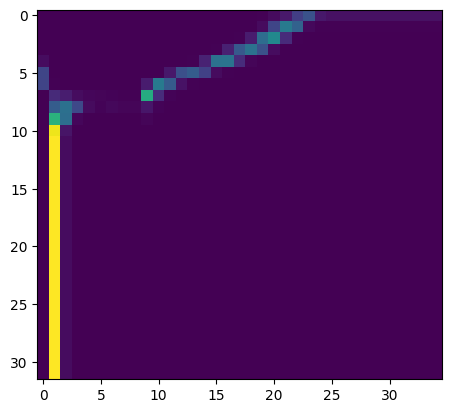

In [ ]:
images = wandb.Image(
    image_array, 
    caption="heatmap"
    )
          
wandb.log({"examples": images}

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib.font_manager import FontProperties
import wandb
import os


def plotConfusion(predictedList, targetList, dataPrepper):
    font_path = '/kaggle/input/notosans/NotoSansDevanagari-VariableFont_wdth,wght.ttf'  # Path to the uploaded TTF font file
    custom_font = FontProperties(fname=font_path)

    plt.rcParams['font.family'] = custom_font.get_name()

    # create characterwise matching of all 67 pairs.
    dictator = dataPrepper.getHinDict()

    characterNames = []
    ticks = []

    for key, value in dictator.items():
        characterNames.append(key)
        ticks.append(value)

    pred = []

    for element in predictedList:
        for tempEle in element:
            pred.append(np.array(tempEle.to("cpu")))

    del (predictedList)
    predArr = np.array(pred)
    del (pred)

    true = []
    for element in targetList:
        for tempEle in element:
            true.append(np.array(tempEle.to("cpu")))

    trueArr = np.array(true)
    del (true)

    trueNP = np.stack(trueArr)
    del (trueArr)

    predNP = np.stack(predArr)
    del (predArr)

    trueNPFlat = trueNP.flatten()
    predNPFlat = predNP.flatten()

    del (trueNP)
    del (predNP)

    print(trueNPFlat.shape)
    print(predNPFlat.shape)

    cm = confusion_matrix(trueNPFlat, predNPFlat)

    cm = cm[3:, 3:]

    fig, ax = plt.subplots(figsize=(24, 24))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar(im)

    labels = characterNames
    plt.xticks(ticks, labels, rotation=90, fontproperties=custom_font)
    plt.yticks(ticks, labels, fontproperties=custom_font)

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    #wandb.init(project='confMatSeq2SeqA3', name='cs22m028')
    #artifact = wandb.Artifact('confusion_matrix', type='confusion_matrix')

    # Save the plot to a file
    plt.savefig('confusion_matrix.png')

    # Add the file to the artifact
    #artifact.add_file('confusion_matrix.png')

    # Log the artifact dictionary
    #wandb.log({'confusion_matrix': artifact})

    # Remove the temporary file
    #os.remove('confusion_matrix.png')

    plt.close()

    plt.tight_layout()
    plt.show()


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
